In [1]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=493480d129c006ee5649f44b99a7c478e29594d3f0ce5aae9d5b84948dea6022
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


Importar las librerias necesarias

In [2]:
from minisom import MiniSom
import numpy as np
from PIL import Image
import math

Colocar datos globales

In [3]:
LEFT_LOOP   = 0
RIGHT_LOOP  = 1
WHORL       = 2
ARCO        = 3

Funciones necesarias

In [4]:
def sobel(I):
    m,n = I.shape# I de 254x254
    Gx = np.zeros([m-2,n-2],np.float32)# Gx de 252x252
    Gy = np.zeros([m-2,n-2],np.float32)# Gy de 252x252
    gx = [[-1,0,1],[ -2,0,2],[ -1,0,1]]
    gy = [[1,2,1],[ 0,0,0],[ -1,-2,-1]]
    for j in range(1,m-2):
        for i in range(1,n-2):
            Gx[j-1,i-1] = sum(sum(I[j-1:j+2,i-1:i+2]*gx))
            Gy[j-1,i-1] = sum(sum(I[j-1:j+2,i-1:i+2]*gy))
    return Gx,Gy

def medfilt2(G,d=3):
    m,n = G.shape
    temp = np.zeros([m+2*(d//2),n+2*(d//2)],np.float32)
    salida = np.zeros([m,n],np.float32)
    temp[1:m+1,1:n+1] = G
    for i in range(1,m):
        for j in range(1,n):
            A = np.asarray(temp[i-1:i+2,j-1:j+2]).reshape(-1)
            salida[i-1,j-1] = np.sort(A)[d+1]
    return salida

def orientacion(patron,w):
    Gx,Gy = sobel(patron)# patron de 254x254
    Gx = medfilt2(Gx)# Gx de 252x252
    Gy = medfilt2(Gy)# Gy de 252x252
    m,n = Gx.shape
    mOrientaciones = np.zeros([m//w,n//w],np.float32)# de una matriz de 18x18
    for i in range(m//w):
        for j in range(n//w):
            YY = sum(sum(2*Gx[i*w:(i+1)*w,j:j+1]*Gy[i*w:(i+1)*w,j:j+1]))
            XX = sum(sum(Gx[i*w:(i+1)*w,j:j+1]**2-Gy[i*w:(i+1)*w,j:j+1]**2))
            #YY = sum(sum(2*Gx[i*w:(i+1)*w,0:1]*Gy[i*w:(i+1)*w,0:1]))
            #XX = sum(sum(Gx[i*w:(i+1)*w,0:1]**2-Gy[i*w:(i+1)*w,0:1]**2))
            mOrientaciones[i,j] = (0.5*math.atan2(YY,XX) + math.pi/2.0)*(180.0/math.pi)
    return mOrientaciones
def representativo(archivo):
    im = Image.open(archivo)
    m,n = im.size
    imarray = np.array(im,np.float32)
    patron = imarray[1:m-1,1:n-1]# de 256x256  a 254x254
    EE = orientacion(patron,14)# retorna EE de 18x18
    return np.asarray(EE).reshape(-1)

Vamos a importar los datos

In [5]:
Xi = np.zeros([15,324],np.float32)# dimension de 15x324
Xi[0,:] = representativo('arco1.tif')
Xi[1,:] = representativo('whorl1.TIF')
Xi[2,:] = representativo('Right1.tif')
Xi[3,:] = representativo('left1.tif')
Xi[4,:] = representativo('Arco2.tif')
Xi[5,:] = representativo('whorl2.tif')
Xi[6,:] = representativo('Right2.tif')
Xi[7,:] = representativo('left2.tif')
Xi[8,:] = representativo('Arco3.tif')
Xi[9,:] = representativo('whorl3.tif')
Xi[10,:] = representativo('Right3.tif')
Xi[11,:] = representativo('left3.tif')
Xi[12,:] = representativo('Arco4.tif')
Xi[13,:] = representativo('whorl4.tif')
Xi[14,:] = representativo('Right4.tif')
print(Xi.shape)
#Yi = [4,3,2,1,4,3,2,1,4,3,2,1,4,3,2]-1
Yi = [3,2,1,0,3,2,1,0,3,2,1,0,3,2,1]
print(len(Yi))

(15, 324)
15


Usar la libreria SOM

In [6]:
max_iter = 5000
alpha_max = 0.5

som = MiniSom(x=10, y=10, input_len=324, sigma=1.0, learning_rate=alpha_max,activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian')
som.random_weights_init(Xi)
som.train_random(data=Xi, num_iteration=max_iter)

Visualizar los datos en la matriz index

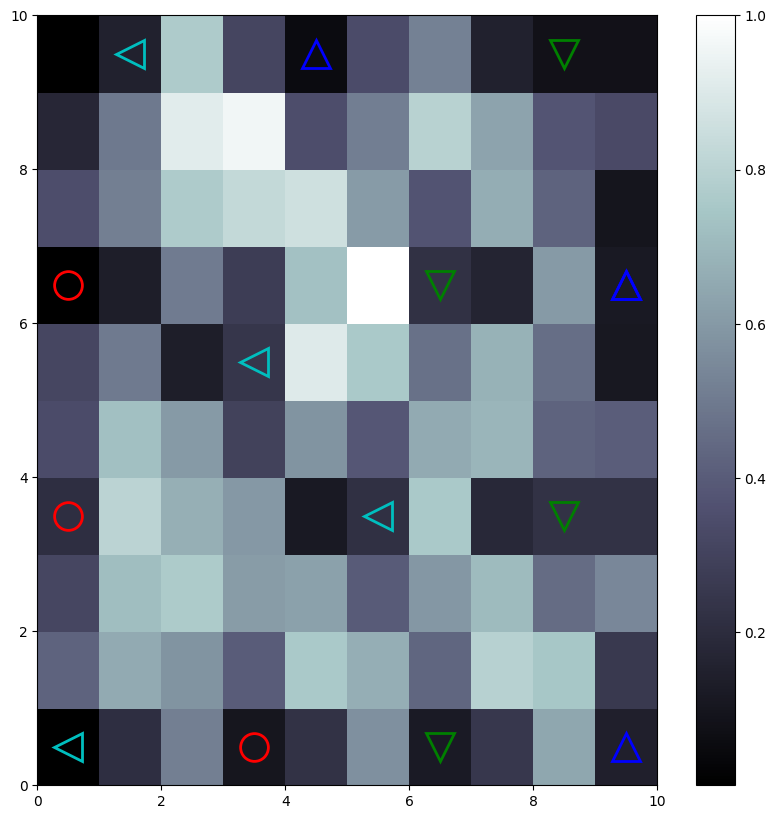

In [7]:
from pylab import bone, pcolor, colorbar, plot, show
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
bone()
pcolor(som.distance_map().T)
colorbar()
valores = [0,1,2,3]
M = np.zeros([10,10],np.float32)-1
markers = ['o', 'v', '^', '<']
colors =  ['r', 'g', 'b', 'c']
for i, x in enumerate(Xi):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[Yi[i]],
         markeredgecolor=colors[Yi[i]],
         markerfacecolor='None',
         markersize=20,
         markeredgewidth=2)
    M[w[0],w[1]] = Yi[i]
show()

La comprobacion a partir de la matriz M

In [8]:
MM = M#np.rot90(M)
print(MM)
np.savetxt('matrizMM.txt', MM, delimiter=" ")
N = MM.astype(str)
N[N=='0.0'] = 'LL'
N[N=='1.0'] = 'RL'
N[N=='2.0'] = 'WH'
N[N=='3.0'] = 'AR'
print("Etiquetas")
print(N)

[[ 3. -1. -1.  0. -1. -1.  0. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.  3.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 0. -1. -1. -1. -1.  3. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.  2.]
 [-1. -1. -1.  3. -1. -1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1.  1. -1. -1. -1. -1. -1.  1.]
 [ 2. -1. -1. -1. -1. -1.  2. -1. -1. -1.]]
Etiquetas
[['AR' '-1.0' '-1.0' 'LL' '-1.0' '-1.0' 'LL' '-1.0' '-1.0' '-1.0']
 ['-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' 'AR']
 ['-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0']
 ['LL' '-1.0' '-1.0' '-1.0' '-1.0' 'AR' '-1.0' '-1.0' '-1.0' '-1.0']
 ['-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' 'WH']
 ['-1.0' '-1.0' '-1.0' 'AR' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0']
 ['RL' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' 'RL' '-1.0' '-1.0' '-1.0']
 ['-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1.0' '-1

Comprobacion

In [14]:
#XX = X[1,:]
"""
Xi[0,:] = representativo('arco1.tif')
Xi[1,:] = representativo('whorl1.TIF')
Xi[2,:] = representativo('Right1.tif')
Xi[3,:] = representativo('left1.tif')
Xi[4,:] = representativo('Arco2.tif')
Xi[5,:] = representativo('whorl2.tif')
Xi[6,:] = representativo('Right2.tif')
Xi[7,:] = representativo('left2.tif')
Xi[8,:] = representativo('Arco3.tif')
Xi[9,:] = representativo('whorl3.tif')
Xi[10,:] = representativo('Right3.tif')
Xi[11,:] = representativo('left3.tif')
Xi[12,:] = representativo('Arco4.tif')
Xi[13,:] = representativo('whorl4.tif')
Xi[14,:] = representativo('Right4.tif')
"""
B = representativo('Right2.tif')
w = som.winner(B)
print(w)
print(MM[w])#
"""
LEFT_LOOP   = 0
RIGHT_LOOP  = 1
WHORL       = 2
ARCO        = 3
"""

(np.int64(8), np.int64(3))
1.0


'\nLEFT_LOOP   = 0\nRIGHT_LOOP  = 1\nWHORL       = 2\nARCO        = 3\n'

In [15]:
Y_simulado = []
for i in range(len(Yi)):
  XX = Xi[i,:]
  w = som.winner(XX)
  if N[w]=="AR":
    Y_simulado.append(3)
  elif N[w]=="WH":
    Y_simulado.append(2)
  elif N[w]=="RL":
    Y_simulado.append(1)
  elif N[w]=="LL":
    Y_simulado.append(0)
  else:
    Y_simulado.append(-1)
print(Y_simulado)

[3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1]


Evaluar precision

In [16]:
precision = 0
for i in range(len(Yi)):
  if Yi[i]==Y_simulado[i]:
    precision = precision + 1
precision = precision/float(len(Yi))
print(precision)

1.0


In [17]:
from sklearn.metrics import confusion_matrix
Matriz_de_Confusion = confusion_matrix(Yi, Y_simulado)
Matriz_de_Confusion
"""sensibilidad"""
sensibilidad = (Matriz_de_Confusion[0,0])/np.sum(Matriz_de_Confusion[0,0]+ Matriz_de_Confusion[1,0])
sensibilidad

np.float64(1.0)

In [18]:
"""especificidad"""
especificidad = (Matriz_de_Confusion[1,1])/np.sum(Matriz_de_Confusion[1,1]+ Matriz_de_Confusion[0,1])
especificidad

np.float64(1.0)

Matriz de Confusión - DATOS ORIGINALES:
 [[3 0 0 0]
 [0 4 0 0]
 [0 0 4 0]
 [0 0 0 4]]
Métricas de Matriz de Confusión - DATOS ORIGINALES:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



/tmp/ipython-input-3450058467.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
/tmp/ipython-input-3450058467.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


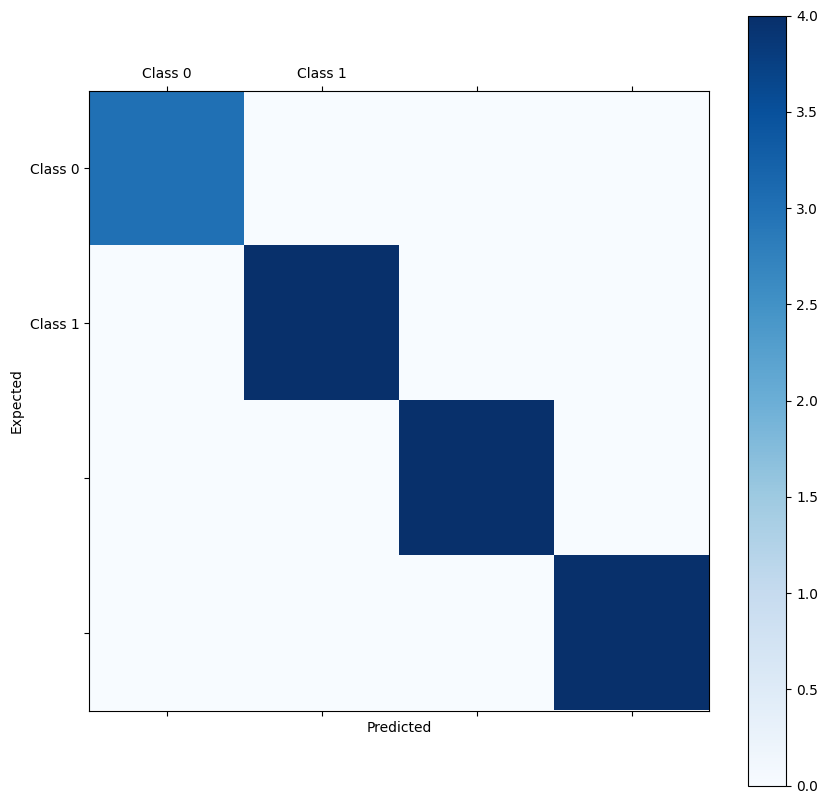

In [19]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

conf_mat = confusion_matrix(y_true=Yi, y_pred=Y_simulado)
print('Matriz de Confusión - DATOS ORIGINALES:\n', conf_mat)
print('Métricas de Matriz de Confusión - DATOS ORIGINALES:\n',classification_report(Yi,Y_simulado))
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Guardar lo aprendido

In [ ]:
"""
import pickle
# almacenando la red som en un archivo som.p
with open('som.p', 'wb') as outfile:
    pickle.dump(som, outfile)
"""

Leer la red som desde un archivo

In [ ]:
"""
with open('som.p', 'rb') as infile:
    som = pickle.load(infile)
"""

In [20]:
# Guardar lo aprendido
import pickle
with open('somhuella.pkl','wb') as outfile:
  pickle.dump(som,outfile)

In [21]:
#abrir lo apdendido
with open("somhuella.pkl", "rb") as tf:
    som_cargado = pickle.load(tf)
B = representativo('arco1.tif')
#XX = Xi[7,:] # representativo('arco1.tif') # arco
w = som_cargado.winner(B)
print(w)
print(MM[w])#

(np.int64(5), np.int64(3))
3.0
